In [2]:
################################# SOURCE #################################
# much of the code in Part 7 was taken from the following sources...
# these sources break down the pre-trained BERT model and enable users to 
# predict on SK-Learn models 
# source 1: https://jalammar.github.io/a-visual-guide-to-using-bert-for-the-first-time/
# source 2: https://github.com/jalammar/jalammar.github.io/blob/master/notebooks/bert/A_Visual_Notebook_to_Using_BERT_for_the_First_Time.ipynb
############################### END SOURCE ###############################

import numpy as np
import pandas as pd
import transformers as ppb # torch transformers
import torch
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV 
from tqdm import tqdm
from Model_ComputeMetrics import getEvaluationMetrics
import Data_Processing as dp

/home/ct/miniconda3/envs/torchEnv/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# get datasets
train, test = dp.importData()
train, test, X_train, X_test = dp.filterData(train, test)

In [4]:
labels_train_encoded, labels_encoded_test = dp.initalizeLabels(train, test) # encode labels

In [5]:
# set up torch device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# set up variables for processing
model_class, tokenizer_class, pretrained_weights = (ppb.DistilBertModel, ppb.DistilBertTokenizer, 'distilbert-base-uncased')

# load the tokenizer and the model of distilbert-base-uncased
tokenizer = tokenizer_class.from_pretrained(pretrained_weights, do_lower_case=True)
model = model_class.from_pretrained(pretrained_weights)

# send the model to the GPU
model = model.to(device)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_layer_norm.bias', 'vocab_projector.weight', 'vocab_transform.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [6]:
# split data into batches
# source: https://www.geeksforgeeks.org/break-list-chunks-size-n-python/

train_batches = np.array_split(pd.Series(train.utterance), 1000)
print('There are ', len(train_batches), ' batches based on ', len(train.utterance), ' utterances')

test_batches = np.array_split(pd.Series(test.utterance), 100)
print('There are ', len(test_batches), ' batches based on ', len(test.utterance), ' utterances')

There are  1000  batches based on  9796  utterances
There are  100  batches based on  720  utterances


In [7]:
# this function utilizes the pre-trained BERT model in batches to extract features
# these features are then used in downstream models to predict classes

def utilizeBERT(dataToModel):
    
    # create empty numpy array 
    output_features = np.empty((0,768), int)

    for batch in tqdm(dataToModel):
        # begin tokenization
        # based on the Jalammar documentation, "this step turns every sentence into a list of ids"
        tokenized = batch.apply(lambda x: tokenizer.encode(x, add_special_tokens=True, max_length=512, truncation=True))

        # padding the data
        # Jalammar: "Before DistilBERT can process this as input, we’ll need to make all the vectors the same size by padding shorter sentences with the token id 0"
        max_len = 0
        for i in tokenized.values:
            if len(i) > max_len:
                max_len = len(i)

        padded = np.array([i + [0]*(max_len-len(i)) for i in tokenized.values])

        # mask the data -> we tell BERT to ignore the padding when processing the input 
        attention_mask = np.where(padded != 0, 1, 0)

        # now run the model and return the "last_hidden_states" which is actually the model output
        input_ids = torch.tensor(padded)
        attention_mask = torch.tensor(attention_mask)

        # send tensors to GPU
        input_ids = input_ids.to(device)
        attention_mask = attention_mask.to(device)

        with torch.no_grad():
            last_hidden_states = model(input_ids, attention_mask=attention_mask)

        # extract features from the model state
        features = last_hidden_states[0][:,0,:].cpu().numpy()
        output_features = np.append(output_features, features, axis=0)

        # clean up memory
        del input_ids
        del attention_mask
        del last_hidden_states
        torch.cuda.empty_cache()
        
    return output_features
    
train_features = utilizeBERT(train_batches)
test_features = utilizeBERT(test_batches)

100%|██████████| 100/100 [00:01<00:00, 55.66it/s]


In [8]:
# MLP
clf = MLPClassifier()
clf.fit(train_features, np.array(labels_train_encoded))
train_predicted_labels = clf.predict(train_features)

In [9]:
# predict on the test set

predictions = clf.predict(test_features)

Training Accuracy: 0.94
f1 score using MLPclassifier is : 0.94


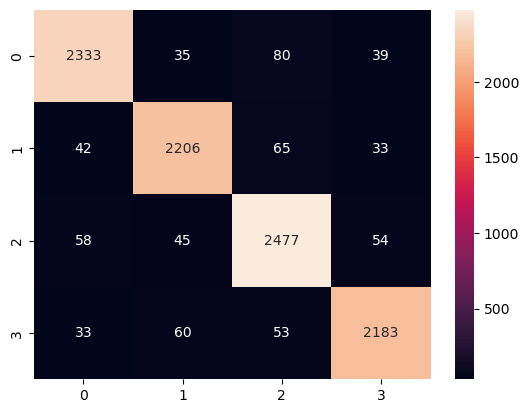

In [10]:
# do some evaluation on the training set

getEvaluationMetrics(np.array(labels_train_encoded), train_predicted_labels, 'MLP', 'Training')

Test Accuracy: 0.65
f1 score using MLPclassifier is : 0.65


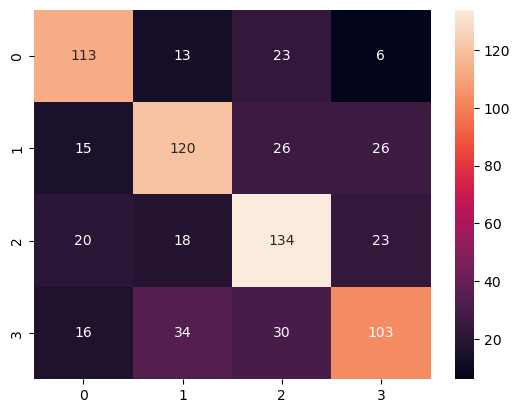

In [11]:
# do some evaluation on the test set

getEvaluationMetrics(np.array(labels_encoded_test), predictions, 'MLP', 'Test')